<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S12/Spatial%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip()
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(1, planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(1, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(1, self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(1, 64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(512*block.expansion, num_classes)


        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x



    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stn(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])



In [17]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 64, 32, 32]           1,728
        GroupNorm-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,864
        GroupNorm-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 5e-4)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
            

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 	Loss: 1.933045

Test set: Average loss: 0.0305, Accuracy: 2360/10000 (24%)

Train Epoch: 2 	Loss: 1.716250

Test set: Average loss: 0.0292, Accuracy: 3124/10000 (31%)

Train Epoch: 3 	Loss: 1.876704

Test set: Average loss: 0.0240, Accuracy: 4402/10000 (44%)

Train Epoch: 4 	Loss: 1.580896

Test set: Average loss: 0.0225, Accuracy: 4730/10000 (47%)

Train Epoch: 5 	Loss: 0.758184

Test set: Average loss: 0.0218, Accuracy: 4891/10000 (49%)

Train Epoch: 6 	Loss: 1.531723

Test set: Average loss: 0.0189, Accuracy: 5631/10000 (56%)

Train Epoch: 7 	Loss: 1.439735

Test set: Average loss: 0.0178, Accuracy: 5927/10000 (59%)

Train Epoch: 8 	Loss: 0.770749

Test set: Average loss: 0.0160, Accuracy: 6402/10000 (64%)

Train Epoch: 9 	Loss: 1.024569

Test set: Average loss: 0.0147, Accuracy: 6606/10000 (66%)

Train Epoch: 10 	Loss: 1.114033

Test set: Average loss: 0.0155, Accuracy: 6491/10000 (65%)

Train Epoch: 11 	Loss: 1.010089

Test set: Average loss: 0.0140, Accuracy: 6874

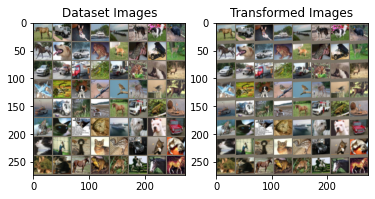

In [19]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


from torch.optim.lr_scheduler import StepLR,OneCycleLR
scheduler = StepLR(optimizer, step_size = 2, gamma=0.5)
for epoch in range(1, 50 + 1):
    train(epoch)
    print("LR = ", scheduler.get_lr())
    test()
    scheduler.step()


# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()